In [1]:
import matplotlib.pyplot as plt
from src.plot_utils import *
from src.sim_utils import *
import yaml
import numpy as np
import jax.numpy as jnp
import sparse
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from pathlib import Path, PosixPath
import h5py

In [2]:
# # PLOT defaults
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.spines.right"] = "False"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["figure.figsize"] = (2,2)
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams["xtick.major.size"] = 1.7
plt.rcParams["ytick.major.size"] = 1.7
plt.rcParams["xtick.major.width"] = 0.25
plt.rcParams["ytick.major.width"] = 0.25
plt.rcParams["figure.dpi"] = 200

SMALL_SIZE = 6
LABEL_SIZE = 7
AXLABEL_SIZE = 8
TITLE_SIZE = 10

plt.rcParams["font.family"] = "Arial" # "Arial"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXLABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LABEL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

plt.rcParams["axes.labelpad"] = 1.5
plt.rcParams["xtick.major.pad"] = 1.5
plt.rcParams["ytick.major.pad"] = 1.5

moduleColors = get_module_colors()

dnColor = "#51bbad"
excColor = "#d84a2e"
inhColor = "#026b85"
mnColor = "#267655"

lightDnColor = "#a7dcd5ff"
lightExcColor = "#ff9985"

dataPath = "/data/users/smpuglie/Pugliese_2025/"

## MANC 1024x DNg100 activation

In [3]:
simType = "DNg100_Stim"
simPath = simType+"/hyak/run_id=28123286"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 4604, 2001)

In [4]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
nMnsActivePastTransient = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    # active neurons
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
    nMnsActivePastTransient.loc[i] = np.sum(activeMnsMaskPastTransient)
    simScore.loc[i] = score

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [5]:
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

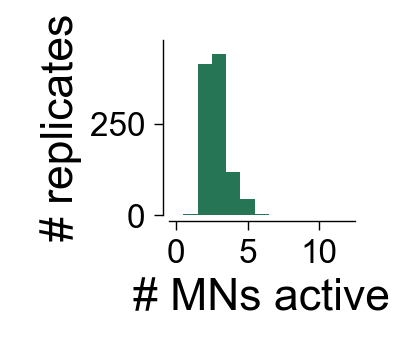

In [6]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

plt.ylim([0,480])
plt.xlim([-0.5,12.5])
plt.xticks([0,5,10],labels=[0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

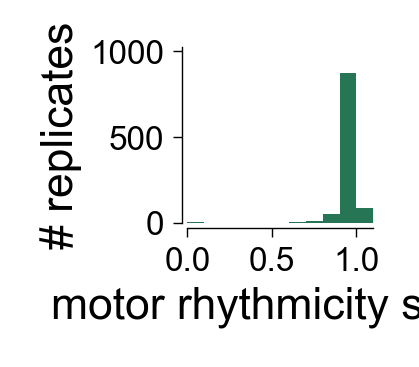

In [7]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()